In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython import display
import torchsummary as ts
import numpy as np

In [2]:
sns.set()
display.set_matplotlib_formats("svg")
plt.rcParams['font.sans-serif'] = "Liberation Sans"
device = torch.device("cuda")

/tmp/ipykernel_161044/2900343767.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [3]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
dataset = datasets.ImageFolder("dataset/faces/", transform=trans)

In [5]:
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, 
                        drop_last=True)

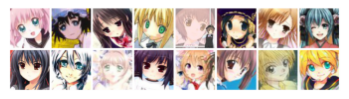

In [6]:
images = make_grid(next(iter(data_loader))[0], normalize=True, padding=5, pad_value=1)
plt.imshow(images.permute(1, 2, 0))
plt.axis("off")
plt.grid(False)

In [7]:
def imshow(data):
    
    images = make_grid(data.detach().cpu() , normalize=True, padding=5, pad_value=1)
    plt.imshow(images.permute(1, 2, 0))
    plt.axis("off")
    plt.grid(False)
    plt.pause(0.0001)

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self,nc=3,ndf=32):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(nc,ndf,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf),
                                 nn.LeakyReLU(0.2,inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(ndf,ndf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf*2),
                                 nn.LeakyReLU(0.2,inplace=True))
        self.layer3 = nn.Sequential(nn.Conv2d(ndf*2,ndf*4,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf*4),
                                 nn.LeakyReLU(0.2,inplace=True))
        self.layer4 = nn.Sequential(nn.Conv2d(ndf*4,ndf*8,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf*8),
                                 nn.LeakyReLU(0.2,inplace=True))
        self.fc = nn.Sequential(nn.Linear(256*6*6,1),nn.Sigmoid())

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(-1,256*6*6)
        out = self.fc(out)
        out = out.reshape(-1)
        return out


In [10]:
class Generator(nn.Module):
    
    def __init__(self,nc=3, ngf=128,nz=1024,feature_size=100):
        super().__init__()
        self.prj = nn.Linear(feature_size,nz*6*6)
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(nz,ngf*4,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*4),
                                 nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(ngf*4,ngf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*2),
                                 nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(ngf*2,ngf,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf),
                                 nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(ngf,nc,kernel_size=4,stride=2,padding=1),
                                 nn.Tanh())

    def forward(self,x):
        out = self.prj(x)
        out = out.view(-1,1024,6,6)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out


In [11]:
netD = Discriminator()

In [12]:
netD(torch.randn(16, 3, 96, 96)).shape

torch.Size([16])

In [13]:
netG = Generator()

In [14]:
netG(torch.randn(16, 100)).shape

torch.Size([16, 3, 96, 96])

In [15]:
BATCH_SIZE = 256
ININT_SIZE = 100
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, 
                         shuffle=True, num_workers=4, drop_last=True)

In [16]:
Epoch = 500
current_epoch = 1
D_losses = []
G_losses = []

In [17]:
generator = Generator().to(device)
discirminator = Discriminator().to(device)
generator.apply(weights_init)
discirminator.apply(weights_init)
criterion = nn.BCELoss()
OPTIMIZER_G = optim.Adam(generator.parameters(), lr=4e-4, betas=(0.5, 0.999))
OPTIMIZER_D = optim.Adam(discirminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [18]:
prebs = []

In [19]:
def display_prebs(data):
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(data)) + 1, 
               [item[0] for item in data], label="pdr", ls="-.")
    ax.plot(np.arange(len(data)) + 1, 
               [item[1] for item in data], label="pdf", ls="--")
    ax.plot(np.arange(len(data)) + 1, 
               [item[2] for item in data], label="pg", ls=":")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Acc")
    ax.set_title("Probs in GAN Training Process")
    plt.savefig("GNA-Probs.svg", format="svg")
    ax.legend()
    plt.pause(0.00001)

In [20]:
discirminator = nn.DataParallel(discirminator, device_ids=[0, 1])
generator = nn.DataParallel(generator, device_ids=[0, 1])
discirminator = discirminator.to("cuda")
generator = generator.to("cuda")

In [21]:
Epoch = 1000
pdr, pdf, pg = None, None, None
for epoch in range(current_epoch, 1 + Epoch):
    dis_temp_loss = []
    gen_temp_loss = []
    temp_pdr = []
    temp_pdf = []
    temp_pg =[]
    for idx, (d, l) in enumerate(data_loader):
        
        d = d.to(device)
        l = l.float().to(device)
        
        out = discirminator(d)
        pdr = out.mean().item()
        real_loss = criterion(out, torch.ones_like(l))
        
        noise = torch.randn(BATCH_SIZE, ININT_SIZE).to(device)
        images = generator(noise)
        out = discirminator(images.detach().to(device))
        pdf = out.mean().item()
        fake_loss = criterion(out, torch.zeros_like(l))
        
        OPTIMIZER_D.zero_grad()
        real_loss.backward()
        fake_loss.backward()
        OPTIMIZER_D.step()
        
        noise = torch.randn(BATCH_SIZE, ININT_SIZE).to(device)
        images = generator(noise)
        out = discirminator(images)
        pg = out.mean().item()
        loss = criterion(out, torch.ones_like(l))
        
        OPTIMIZER_G.zero_grad()
        loss.backward()
        OPTIMIZER_G.step()
        
        d_loss = fake_loss + real_loss
        
        temp_pdr.append(pdr)
        temp_pdf.append(pdf)
        temp_pg.append(pg)
        
        print("Epoch = {:<2} Step[{:3}/{:3}] Dis-Loss = {:.5f} Gen-Loss = {:.5f} Acc = {:.2f} {:.2f} {:.2f}"\
              .format(current_epoch, idx + 1, len(data_loader), d_loss.item(), 
                      loss.item(), pdr, pdf, pg))
        
        dis_temp_loss.append(d_loss.item())
        gen_temp_loss.append(loss.item())
    D_losses.append(np.mean(dis_temp_loss))
    G_losses.append(np.mean(gen_temp_loss))
    current_epoch +=1 
    prebs.append((np.mean(temp_pdr), np.mean(temp_pdf), np.mean(temp_pg)))
    if epoch > 1:
        fig, ax = plt.subplots()
        ax.plot(np.arange(len(D_losses)) + 1, 
                   D_losses, label="Discriminator", ls="-.")
        ax.plot(np.arange(len(G_losses)) + 1, 
                   G_losses, label="Generator", ls="--")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title("GAN Training process")
        ax.legend(bbox_to_anchor=[1, 1.02])
        plt.pause(0.0001)
        imshow(images[:16])
        imshow(d[:16])
        display_prebs(prebs)
    if epoch % 10 == 0:
        display.clear_output()

Epoch = 1  Step[  1/200] Dis-Loss = 1.41223 Gen-Loss = 0.90255 Acc = 0.48 0.47 0.41
Epoch = 1  Step[  2/200] Dis-Loss = 2.23117 Gen-Loss = 0.33607 Acc = 0.60 0.81 0.72
Epoch = 1  Step[  3/200] Dis-Loss = 2.96342 Gen-Loss = 0.19054 Acc = 0.62 0.91 0.83
Epoch = 1  Step[  4/200] Dis-Loss = 3.36881 Gen-Loss = 0.13555 Acc = 0.61 0.94 0.87
Epoch = 1  Step[  5/200] Dis-Loss = 3.62727 Gen-Loss = 0.12014 Acc = 0.60 0.95 0.89
Epoch = 1  Step[  6/200] Dis-Loss = 3.71926 Gen-Loss = 0.10951 Acc = 0.57 0.95 0.90
Epoch = 1  Step[  7/200] Dis-Loss = 3.73998 Gen-Loss = 0.11182 Acc = 0.57 0.95 0.90
Epoch = 1  Step[  8/200] Dis-Loss = 3.81553 Gen-Loss = 0.11057 Acc = 0.53 0.95 0.90
Epoch = 1  Step[  9/200] Dis-Loss = 3.71718 Gen-Loss = 0.11358 Acc = 0.54 0.95 0.89
Epoch = 1  Step[ 10/200] Dis-Loss = 3.68828 Gen-Loss = 0.11479 Acc = 0.53 0.95 0.89
Epoch = 1  Step[ 11/200] Dis-Loss = 3.60339 Gen-Loss = 0.12641 Acc = 0.53 0.94 0.88
Epoch = 1  Step[ 12/200] Dis-Loss = 3.57151 Gen-Loss = 0.14207 Acc = 0.52 0.

KeyboardInterrupt: 

In [ ]:
torch.save(generator.state_dict(), "gen_final.pkl")

In [ ]:
torch.save(discirminator.state_dict(), "dis_final.pkl")

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(D_losses)) + 1, 
           D_losses, label="Discriminator", ls="-.")
ax.plot(np.arange(len(G_losses)) + 1, 
           G_losses, label="Generator", ls="--")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("GAN Training process")
ax.legend()
plt.savefig("GNA-Loss.svg", format="svg")

In [ ]:
generator.load_state_dict(torch.load("gen_final.pkl"))

In [135]:
generator = generator.eval()
with torch.no_grad():
    noise = torch.randn(16, ININT_SIZE).to(device)
    images = generator(noise)

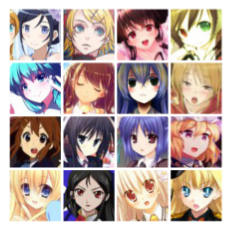

In [137]:
data = make_grid(d[:16].detach().cpu() , nrow=4,
                   normalize=True, padding=5, pad_value=1)
plt.imshow(data.permute(1, 2, 0))
plt.axis("off")
plt.grid(False)
plt.savefig("RealAnimation.png", format="png", dpi=200)

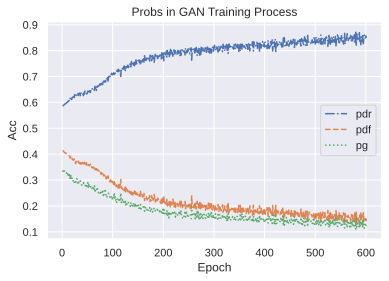

In [140]:
display_prebs(prebs)